In [1]:
### Import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import random
from tensorflow.keras.preprocessing import image_dataset_from_directory as tf_img
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import pathlib
import glob
import os
import cv2 as cv
from PIL import Image

In [2]:
## Defining path of train and test set

train_dir = pathlib.Path("Train/")
test_dir = pathlib.Path("Test/")

In [3]:
## Train & test set image count

image_count_train = len(list(train_dir.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(test_dir.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [4]:
## Declaring variable for model fit

batch_size = 32
img_height = 180
img_width = 180
num_classes = 9

In [5]:
## Defining train set 

train_ds = tf_img(
    directory=train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(180,180),
    seed=123,
    validation_split=0.2,
    subset='training'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
## Defining validation set 

val_ds = tf_img(
    directory=train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(180,180),
    seed=123,
    validation_split=0.2,
    subset='validation'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [8]:
## EDA part

In [9]:
list_of_disease = list(class_names)

In [10]:
len_images = []
for i in list_of_disease:
    len_images.append(len(glob.glob('Train/'+i+'/*')))

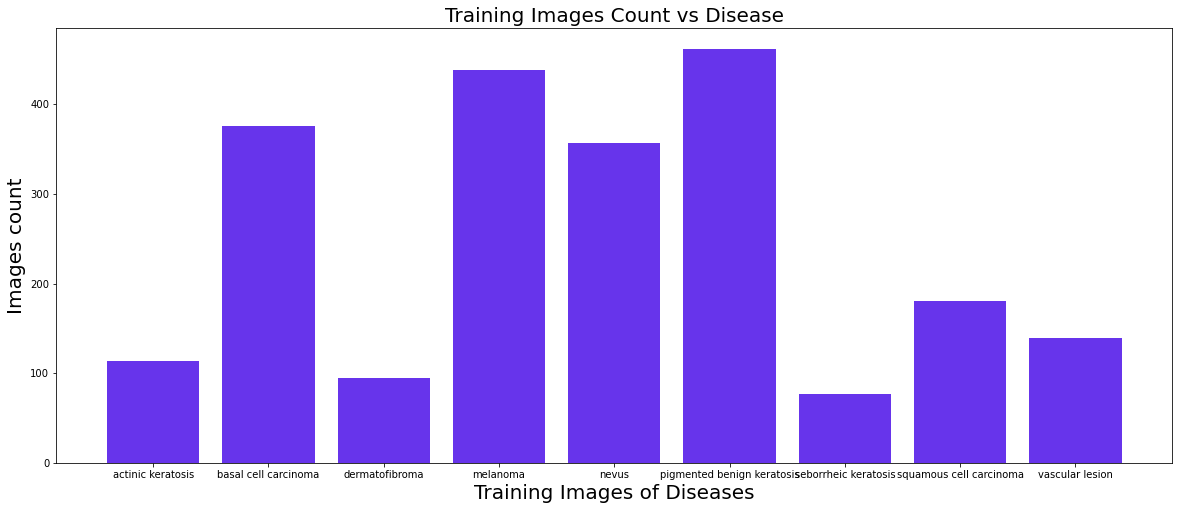

In [11]:
plt.figure(figsize=(20,8))
plt.bar(list_of_disease,len_images, color='#6734eb')
plt.xlabel('Training Images of Diseases', fontsize=20)
plt.ylabel('Images count', fontsize=20)
plt.title('Training Images Count vs Disease', fontsize=20)
plt.show()

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
## Defining model type

model = Sequential()

In [14]:
## Model compile with required parameter

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [15]:
## Normalization 

normalization_layer = Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [16]:
## Defining layer for model without droput

img_rows, img_cols = 180, 180
input_shape = (img_rows, img_cols, 3)

## First Conv layer
model.add(Conv2D(16, kernel_size=4,activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(4,4)))

## Second Conv layer

model.add(Conv2D(32, kernel_size=4,activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))

## Third Conv layer

model.add(Conv2D(128, kernel_size=4,activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))



model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))


model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 177, 177, 16)      784       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 44, 44, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 41, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         65664     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

In [17]:
## Model fit with 20 epochs

epochs = 20
history = model.fit(train_ds,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=val_ds)

Epoch 1/20
56/56 [==============================] - 24s 417ms/step - loss: 3.2393 - accuracy: 0.2199 - val_loss: 1.9572 - val_accuracy: 0.2931
Epoch 2/20
56/56 [==============================] - 21s 370ms/step - loss: 1.8023 - accuracy: 0.3320 - val_loss: 1.6728 - val_accuracy: 0.4183
Epoch 3/20
56/56 [==============================] - 19s 335ms/step - loss: 1.6666 - accuracy: 0.3940 - val_loss: 1.5708 - val_accuracy: 0.4452
Epoch 4/20
56/56 [==============================] - 22s 402ms/step - loss: 1.5488 - accuracy: 0.4526 - val_loss: 1.5619 - val_accuracy: 0.4139
Epoch 5/20
56/56 [==============================] - 36s 653ms/step - loss: 1.5467 - accuracy: 0.4459 - val_loss: 1.4926 - val_accuracy: 0.4944
Epoch 6/20
56/56 [==============================] - 29s 508ms/step - loss: 1.4810 - accuracy: 0.4715 - val_loss: 1.5263 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 25s 449ms/step - loss: 1.4172 - accuracy: 0.4849 - val_loss: 1.4376 - val_accuracy: 0.5034

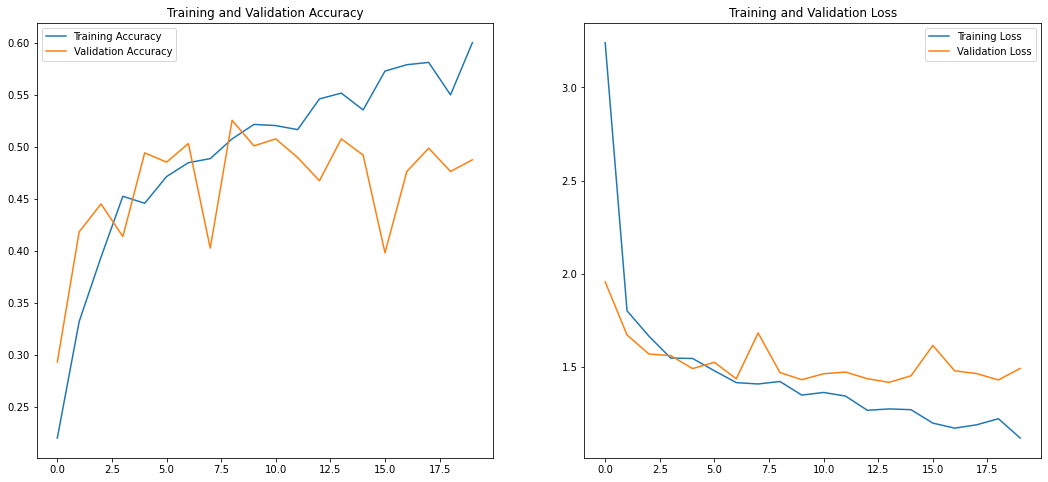

In [18]:
## EDA of model accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
## The model seems to be overfitting as the difference in accuracy of train and validation set is high. Let's try with
## dropout to solve the overfitting issue

In [20]:
## Defining model type

model2 = Sequential()

In [21]:
## Model compile with required parameter

model2.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [22]:
## Model fit with droput layer to solve overfitting issue

img_rows, img_cols = 180, 180
input_shape = (img_rows, img_cols, 3)

## First Conv layer
model2.add(Conv2D(16, kernel_size=4,activation='relu',input_shape=input_shape))
model2.add(MaxPooling2D(pool_size=(4,4)))
model2.add(Dropout(0.20))

## Second Conv layer

model2.add(Conv2D(32, kernel_size=4,activation='relu'))
model2.add(MaxPooling2D(pool_size=(4,4)))
model2.add(Dropout(0.20))

## Third Conv layer

model2.add(Conv2D(128, kernel_size=4,activation='relu'))
model2.add(MaxPooling2D(pool_size=(4,4)))
model2.add(Dropout(0.25))



model2.add(Flatten())

model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))


model2.add(Dense(num_classes, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 177, 177, 16)      784       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 44, 44, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 44, 44, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 32)        8224      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)        

In [23]:
## Model fit with 30 epochs

epochs = 30
history = model2.fit(train_ds,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=val_ds)

Epoch 1/30
56/56 [==============================] - 28s 485ms/step - loss: 4.8812 - accuracy: 0.1741 - val_loss: 2.0356 - val_accuracy: 0.2528
Epoch 2/30
56/56 [==============================] - 25s 444ms/step - loss: 2.0482 - accuracy: 0.2277 - val_loss: 1.9634 - val_accuracy: 0.3110
Epoch 3/30
56/56 [==============================] - 25s 452ms/step - loss: 1.9882 - accuracy: 0.2584 - val_loss: 1.9089 - val_accuracy: 0.2864
Epoch 4/30
56/56 [==============================] - 19s 347ms/step - loss: 1.9195 - accuracy: 0.2857 - val_loss: 1.8518 - val_accuracy: 0.3132
Epoch 5/30
56/56 [==============================] - 20s 358ms/step - loss: 1.8113 - accuracy: 0.3209 - val_loss: 1.7943 - val_accuracy: 0.3714
Epoch 6/30
56/56 [==============================] - 30s 543ms/step - loss: 1.7331 - accuracy: 0.3622 - val_loss: 1.7191 - val_accuracy: 0.3826
Epoch 7/30
56/56 [==============================] - 30s 533ms/step - loss: 1.7449 - accuracy: 0.3504 - val_loss: 1.6972 - val_accuracy: 0.3870

In [24]:
#### The overfitting issue is now resolved by dropout. Still the accuracy score of both train and test set is very low
#### Let's try with data augmentation for imbalance class

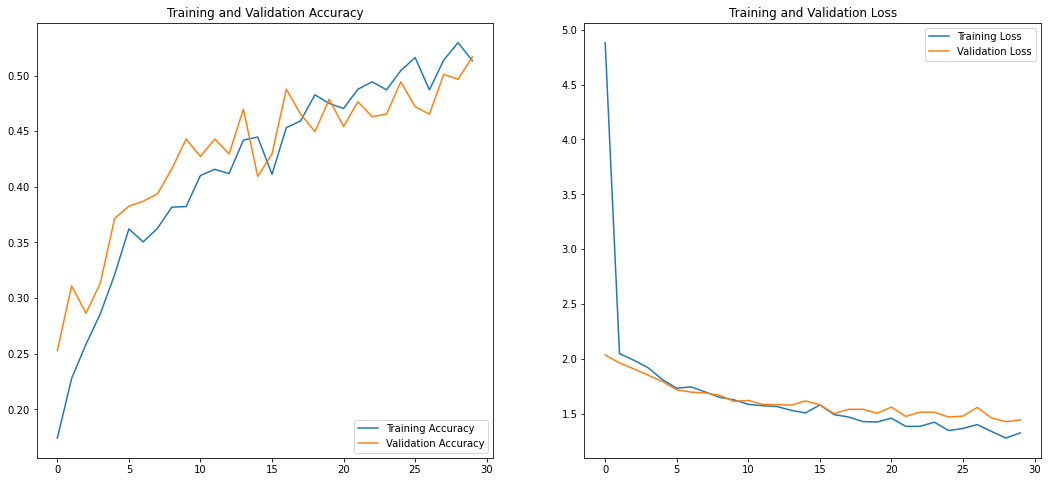

In [25]:
## EDA of model accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
!pip install Augmentor

In [27]:
import Augmentor

In [28]:
path_to_training_dataset = train_dir


In [29]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [30]:
## Data Augmentation

for i in class_names:
    p = Augmentor.Pipeline('{}/{}/'.format(path_to_training_dataset,i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDB05978040>:   0%|          | 1/500 [00:00<01:04,  7.68 Samples/s]

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDB05CAE5E0>: 100%|██████████| 500/500 [00:11<00:00, 41.78 Samples/s]                  
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDB05CCD760>:   0%|          | 1/500 [00:00<01:26,  5.80 Samples/s]                  

Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDB0568DD30>: 100%|██████████| 500/500 [00:11<00:00, 41.87 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDB05C8A5E0>: 100%|██████████| 500/500 [00:11<00:00, 42.97 Samples/s]                  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=960x724 at 0x7FDB0596B3A0>:   0%|          | 1/500 [00:00<01:00,  8.21 Samples/s]

Initialised with 438 image(s) found.
Output directory set to Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDB059A3100>: 100%|██████████| 500/500 [01:05<00:00,  7.66 Samples/s]                   
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=959x723 at 0x7FDB05C2E970>: 100%|██████████| 500/500 [00:51<00:00,  9.75 Samples/s]                    
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDB5C640670>: 100%|██████████| 500/500 [00:12<00:00, 41.45 Samples/s]                  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDB05996A90>: 100%|██████████| 500/500 [00:28<00:00, 17.71 Samples/s]                  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDB05964880>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDB0923A2B0>: 100%|██████████| 500/500 [00:10<00:00, 46.93 Samples/s]                  
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDB05996CD0>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDBA35B76A0>: 100%|██████████| 500/500 [00:10<00:00, 47.46 Samples/s]                  


In [31]:
list_of_disease

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [32]:
image_count_train = len(list(train_dir.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [33]:
## Defining training set

train_ds2 = tf_img(
    directory=train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(180,180),
    seed=123,
    validation_split=0.2,
    subset='training'
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [34]:
## Defining validation set

val_ds2 = tf_img(
    directory=train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(180,180),
    seed=123,
    validation_split=0.2,
    subset='validation'
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [35]:
## Defining model type

model3 = Sequential()

In [36]:
## Model compile with required parameter

model3.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [37]:
## Normalization
normalization_layer = Rescaling(1./255)

normalized_ds = train_ds2.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [38]:
## Model fit with data augmentation

img_rows, img_cols = 180, 180
input_shape = (img_rows, img_cols, 3)

## First Conv layer
model3.add(Conv2D(16, kernel_size=4,activation='relu',input_shape=input_shape))
model3.add(MaxPooling2D(pool_size=(4,4)))


## Second Conv layer

model3.add(Conv2D(32, kernel_size=4,activation='relu'))
model3.add(MaxPooling2D(pool_size=(4,4)))


## Third Conv layer

model3.add(Conv2D(128, kernel_size=4,activation='relu'))
model3.add(MaxPooling2D(pool_size=(4,4)))


model3.add(Flatten())

model3.add(Dense(128, activation='relu'))
model3.add(Dense(64, activation='relu'))


model3.add(Dense(num_classes, activation='softmax'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 177, 177, 16)      784       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 44, 44, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 41, 41, 32)        8224      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 128)         65664     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)              

In [39]:
## Model fit with 50 epochs

epochs = 50
history = model3.fit(train_ds2,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=val_ds2)

Epoch 1/50
169/169 [==============================] - 87s 504ms/step - loss: 3.3030 - accuracy: 0.2632 - val_loss: 1.6651 - val_accuracy: 0.3749
Epoch 2/50
169/169 [==============================] - 86s 505ms/step - loss: 1.6012 - accuracy: 0.3782 - val_loss: 1.5225 - val_accuracy: 0.3979
Epoch 3/50
169/169 [==============================] - 87s 506ms/step - loss: 1.5097 - accuracy: 0.4156 - val_loss: 1.5560 - val_accuracy: 0.3972
Epoch 4/50
169/169 [==============================] - 86s 503ms/step - loss: 1.4973 - accuracy: 0.4314 - val_loss: 1.4348 - val_accuracy: 0.4477
Epoch 5/50
169/169 [==============================] - 86s 501ms/step - loss: 1.4126 - accuracy: 0.4588 - val_loss: 1.2740 - val_accuracy: 0.4959
Epoch 6/50
169/169 [==============================] - 91s 529ms/step - loss: 1.3449 - accuracy: 0.4870 - val_loss: 1.2566 - val_accuracy: 0.4848
Epoch 7/50
169/169 [==============================] - 86s 504ms/step - loss: 1.3012 - accuracy: 0.5045 - val_loss: 1.3952 - val_ac

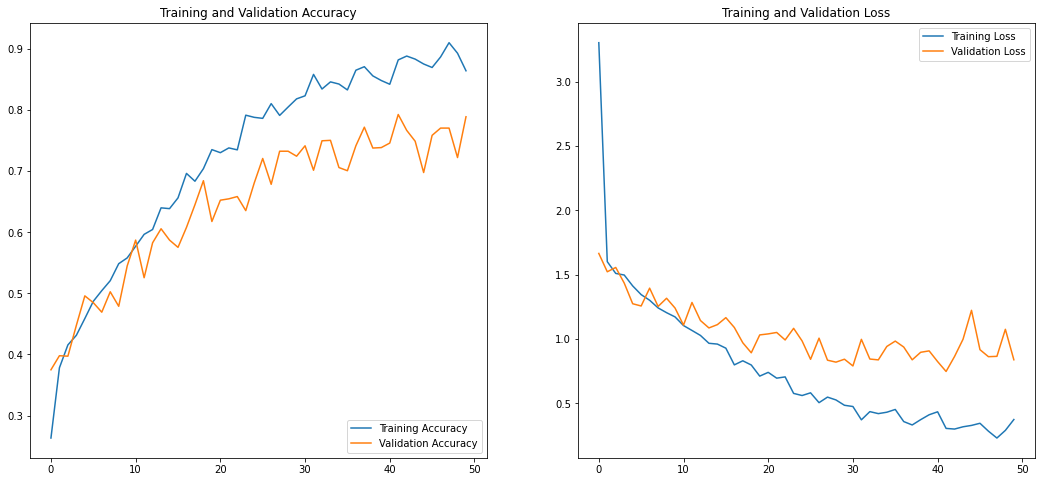

In [40]:
## EDA of model accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### By data augmentation we can get the rid of overfitting issue. After data augmentation the accuracy score of train and test set increases with less difference as compared to earlier model.
